## Introduction and Data Description

MNIST ('Modified National Institute of Standards and Technology') is basically the 'hello world' dataset of computer vision. Our goal is to correctly identify digits from a dataset of tens of thousands of handwritten images.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

## Importing the Required Libraries

In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import itertools
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time

## Loading and Exploring the Data

In [2]:
mnist = fetch_openml('mnist_784')

In [3]:
mnist

{'data':        pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 ...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
 69995     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69997     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69999     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 
      

In [4]:
# Separate images and labels
X, y = mnist['data'], mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

## Splitting into training and testing sets 

In [7]:
X_train = X[:60000]
X_test = X[60000:]
y_train = y[:60000]
y_test = y[60000:]

## Reshaping the Image Vector/1D Array into a 3D Array

In [10]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_train.shape

(60000, 28, 28, 1)

In [11]:
X_test = X_test.values.reshape(-1, 28, 28, 1)
X_test.shape

(10000, 28, 28, 1)

## Shuffling training data

In [12]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Scaling the Data

In [15]:
# Feature scaling is mandatory for Neural Networks. The following computation would cause all pxiel-values to lie in 
# the range [0, 1].

X_train = X_train/255.0
X_test = X_test/255.0

## One-Hot-Encoding the Label Array

In [16]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)

In [19]:
print(y_train[0])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


## Data Augmentation

In [20]:
# Dataset augmentation applies transformations to your training examples: flipping, zooming, etc. The idea is that by 
# changing the makeup of your data, you can improve your performance (& reduce overfitting) and increase your training 
# set size.

datagen = ImageDataGenerator(shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
datagen.fit(X_train)

## Visualizing the Dataset

Here, we look at the first 10 imags of the dataset.

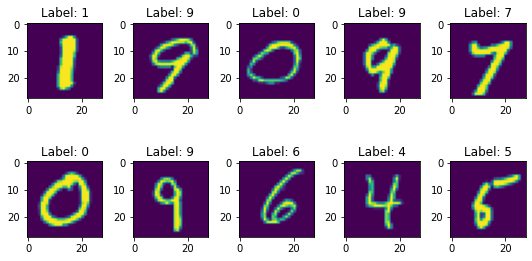

In [21]:
num = 10
images = X_train[:num]

num_row = 2
num_col = 5

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize = (1.5*num_col, 2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i].reshape(28, 28), cmap = 'viridis')
    ax.set_title('Label: {}'.format(y_train[i].tolist().index(1.0, 0, 10)))
plt.tight_layout()
plt.show()

## Getting Validation Data from the Training Set

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25)
print(X_train.shape)
print(X_val.shape)

(45000, 28, 28, 1)
(15000, 28, 28, 1)


## Building a CNN using Keras

The Convolutional Neural Network (CNN) we are implementing here is the seminal LeNet architecture, first proposed by one of the grandfathers of deep learning, Yann LeCunn.

By today’s standards, LeNet is a very shallow neural network, consisting of the following layers:
(CONV => RELU => POOL) * 2 => FC => RELU => FC => SOFTMAX

In [23]:
# Adding the input layer
input_layer = tf.keras.layers.Input(shape = (28, 28, 1))

# Adding the first convolutional layer and a max pooling layer
hidden_layer_1 = tf.keras.layers.Conv2D(20, kernel_size = (5, 5), activation = tf.keras.activations.relu)(input_layer)
pool_layer_1 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(hidden_layer_1)

# Adding the second convolutional and max pooling layers
hidden_layer_2 = tf.keras.layers.Conv2D(50, kernel_size = (5, 5), activation = tf.keras.activations.relu)(pool_layer_1)
pool_layer_2 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(hidden_layer_2)

# Adding the flattening layer
flatten_layer = tf.keras.layers.Flatten()(pool_layer_2)

# Adding a fully connected hidden layer
hidden_layer_3 = tf.keras.layers.Dense(500, activation = tf.keras.activations.relu)(flatten_layer)

# Adding the output layer
output_layer = tf.keras.layers.Dense(10, activation = tf.keras.activations.sigmoid)(hidden_layer_3)

In [24]:
model = tf.keras.Model(inputs = input_layer, outputs = output_layer)

## Compiling and Training the CNN

In [25]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])

In [ ]:
start_time = time.time()

In [26]:
evln = model.fit(X_train, y_train, batch_size = 64, epochs = 10, validation_data = (X_val, y_val))

Epoch 1/10
704/704 [==============================] - 14s 19ms/step - loss: 0.1593 - accuracy: 0.9526 - val_loss: 0.0727 - val_accuracy: 0.9777
Epoch 2/10
704/704 [==============================] - 13s 18ms/step - loss: 0.0476 - accuracy: 0.9853 - val_loss: 0.0462 - val_accuracy: 0.9859
Epoch 3/10
704/704 [==============================] - 13s 18ms/step - loss: 0.0304 - accuracy: 0.9901 - val_loss: 0.0406 - val_accuracy: 0.9869
Epoch 4/10
704/704 [==============================] - 13s 19ms/step - loss: 0.0227 - accuracy: 0.9924 - val_loss: 0.0473 - val_accuracy: 0.9847
Epoch 5/10
704/704 [==============================] - 13s 18ms/step - loss: 0.0170 - accuracy: 0.9946 - val_loss: 0.0364 - val_accuracy: 0.9893
Epoch 6/10
704/704 [==============================] - 13s 19ms/step - loss: 0.0148 - accuracy: 0.9952 - val_loss: 0.0471 - val_accuracy: 0.9871
Epoch 7/10
704/704 [==============================] - 13s 18ms/step - loss: 0.0121 - accuracy: 0.9958 - val_loss: 0.0408 - val_accuracy:

In [ ]:
end_time = time.time()
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))

## Plotting the Evolution of Model Accuracy

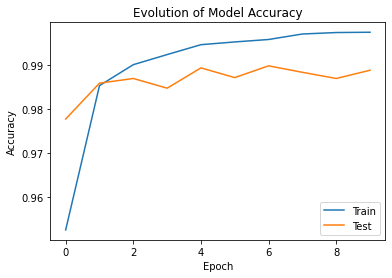

In [27]:
plt.plot(evln.history['accuracy'])
plt.plot(evln.history['val_accuracy'])
plt.title('Evolution of Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

## Plotting the Evolution of Model Loss

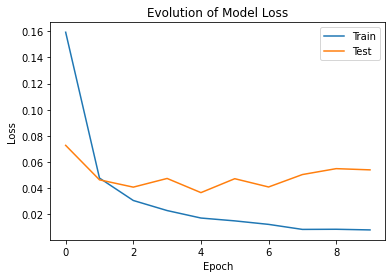

In [28]:
plt.plot(evln.history['loss'])
plt.plot(evln.history['val_loss'])
plt.title('Evolution of Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Predicting Test Set Results

In [29]:
results = model.predict(X_test)
print(results)

[[5.6461213e-05 9.3626976e-04 3.9417356e-02 ... 1.0000000e+00
  4.3948810e-05 2.1514893e-03]
 [7.0138711e-01 9.7721219e-03 1.0000000e+00 ... 1.4659786e-01
  4.7406655e-05 3.3086230e-06]
 [3.1195283e-03 9.9999869e-01 1.8961489e-02 ... 9.1340011e-01
  1.1734068e-03 1.2844801e-03]
 ...
 [1.1179101e-09 4.9177289e-02 1.4995808e-06 ... 3.2510489e-02
  3.7933281e-01 4.1196257e-02]
 [2.4432882e-06 2.7318902e-07 9.5968167e-10 ... 8.6994623e-06
  9.8723221e-01 2.3773909e-03]
 [6.1263740e-03 6.0084108e-06 8.8981277e-01 ... 4.0093447e-08
  1.4752150e-04 4.4719686e-09]]


In [30]:
# np.argmax returns the indices of the maximum values along an axis
results = np.argmax(results, axis = 1)

# Putting the results into a series named 'Predicted Digits'
results = pd.Series(results, name = 'Predicted Digits')

print(results)

0       7
1       2
2       1
3       0
4       4
       ..
9995    2
9996    3
9997    4
9998    5
9999    6
Name: Predicted Digits, Length: 10000, dtype: int64


In [41]:
print(classification_report(np.array(y_test), np.asarray(results, dtype = 'str')))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.97      1.00      0.98      1032
           3       0.99      1.00      0.99      1010
           4       1.00      0.98      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

